# Image Classification using AWS SageMaker

In this project, we use PyTorch to apply a convolutional neural network for image classification. We use transfer learning to use a pre-trained model, and then adapt it to the specific task in this exercise. The sample dataset is about dog breed classification.

In addition, one of the main tasks of the exercise is to set up the ML workflow

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

from sagemaker.pytorch import PyTorch
import numpy as np
import os, os.path

In [4]:
s3_bucket = 'aj-aws-project3'
s3_dir = f's3://{s3_bucket}/data/'
s3_dir

's3://aj-aws-project3/data/'

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

The provided dataset is about dogbreed classification. It can be downloaded form this [link](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).

The dataset contains images of 133 different dog breeds. For each breed, a different number of images is available. Each breed has its own image directory. The dataset is split up into test, train and validation datasets.

There are 6687 training images, 836 test images and 835 validation images.

The class names correspond to the directory names, e.g., "Affenpinscher", "Afghan_hound" etc.

In [ ]:
#TODO: Fetch and upload the data to AWS S3
# Would be faster:
#!aws s3 cp s3://udacity-aind/dog-project/dogImages.zip ./
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [5]:
# S3 ARN: arn:aws:s3:::aj-aws-project3
!aws s3 sync ./dogImages/ s3://aj-aws-project3/data/

In [15]:
# Count number of images in a directory
count = 0
for root_dir,cur_dir,files in os.walk(r'./dogImages/valid'):
    count += len(files)
print('file count: ', count)

file count:  835


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [20]:
#TODO: Declare your HP ranges, metrics etc.
# From zip-file in: 11. Hyperparameter Tuning in Sagemaker
# pytorch_mnist_hpo.ipynb
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

# For testing
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 512]),
}

#hyperparameter_ranges = {
#    "lr": ContinuousParameter(0.001, 0.1),
#    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
#}

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [26]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py38',
    framework_version="1.9",
    instance_count=1,
    instance_type="ml.m5.2xlarge"
)# TODO: Your estimator here
# ml.m5.large is too small for this training set :(

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type
)# TODO: Your HP tuner here

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({"training": f"s3://aj-aws-project3/data"}) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................................................................................

In [19]:
# Retrieve hyperparameter tuning job
# (continuing the notebook later!)
from sagemaker.tuner import HyperparameterTuner
tuner = HyperparameterTuner.attach("pytorch-training-230221-2133")

In [20]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator_hyperparams = best_estimator.hyperparameters()


2023-02-21 22:02:19 Starting - Found matching resource for reuse
2023-02-21 22:02:19 Downloading - Downloading input data
2023-02-21 22:02:19 Training - Training image download completed. Training in progress.
2023-02-21 22:02:19 Uploading - Uploading generated training model
2023-02-21 22:02:19 Completed - Resource released due to keep alive period expiry


In [21]:
best_estimator_hyperparams

{'_tuning_objective_metric': '"Test Loss"',
 'batch-size': '"32"',
 'lr': '0.0032505765136462395',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-21-21-33-25-866"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-128620648510/pytorch-training-2023-02-21-21-33-25-866/source/sourcedir.tar.gz"'}

In [22]:
tuner.describe()['HyperParameterTuningJobName']

'pytorch-training-230221-2133'

In [23]:
best_estimator_hyperparams['batch-size']

'"32"'

In [24]:
best_estimator_hyperparams['lr']

'0.0032505765136462395'

In [25]:
tuner.analytics().dataframe()

,batch-size,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""32""",0.003251,pytorch-training-230221-2133-004-5f79cb85,Completed,0.065263,2023-02-21 21:57:49+00:00,2023-02-21 22:02:17+00:00,268.0
1,"""32""",0.001084,pytorch-training-230221-2133-003-c320b9e0,Completed,0.066843,2023-02-21 21:52:33+00:00,2023-02-21 21:57:05+00:00,272.0
2,"""512""",0.096445,pytorch-training-230221-2133-002-70dd903a,Completed,77.830025,2023-02-21 21:44:01+00:00,2023-02-21 21:51:04+00:00,423.0
3,"""512""",0.089827,pytorch-training-230221-2133-001-1143ce62,Completed,61.521866,2023-02-21 21:34:46+00:00,2023-02-21 21:42:14+00:00,448.0


In [26]:
hyperparameters = {
    "batch-size":int(best_estimator_hyperparams['batch-size'].replace('"','')),
    "lr":best_estimator_hyperparams['lr'],
    "hpo":0
}  
hyperparameters

{'batch-size': 32, 'lr': '0.0032505765136462395', 'hpo': 0}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

Using the same hpy.py with an additional hook for both use cases.

In [11]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule, #profiler
    ProfilerConfig, #profiler
    FrameworkProfile, #profiler
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [12]:
hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "1", 
                     "eval.save_interval": "1"}
)

In [13]:
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [14]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

role = sagemaker.get_execution_role()

data_location = f"s3://{s3_bucket}/data/"
output_location=f"s3://{s3_bucket}/output/"
data_location

's3://aj-aws-project3/data/'

In [27]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="aj-project3",
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    hyperparameters=hyperparameters,
    py_version='py38',
    framework_version="1.9",
    ## Debugger parameters
    rules=rules,
    output_path=output_location,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [28]:
estimator.fit({"training": data_location}, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: aj-project3-2023-03-19-15-43-32-496


In [15]:
# Retrieve estimator, not continuing right away
from sagemaker.pytorch import PyTorch
estimator = PyTorch.attach("aj-project3-2023-03-19-15-43-32-496")


2023-02-28 22:44:14 Starting - Preparing the instances for training
2023-02-28 22:44:14 Downloading - Downloading input data
2023-02-28 22:44:14 Training - Training image download completed. Training in progress.
2023-02-28 22:44:14 Uploading - Uploading generated training model
2023-02-28 22:44:14 Completed - Training job completed


In [16]:
debug_output_path = estimator.latest_job_debugger_artifacts_path()
print(debug_output_path)

None


In [ ]:
from smdebug.trials import create_trial
trial = create_trial(debug_output_path)

In [29]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [30]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-03-19 16:06:56.011 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:24 INFO s3_trial.py:42] Loading trial debug-output at path s3://aj-aws-project3/output/aj-project3-2023-03-19-15-43-32-496/debug-output
[2023-03-19 16:06:57.006 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:24 WARNING s3handler.py:184] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 236 more expected)', IncompleteRead(0 bytes read, 236 more expected)) while reading s3://aj-aws-project3/output/aj-project3-2023-03-19-15-43-32-496/debug-output/index/000000000/000000000064_worker_0.json . Will retry now


In [31]:
trial.tensor_names()

[2023-03-19 16:07:02.303 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:24 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-03-19 16:07:03.323 pytorch-1-13-cpu-py39-ml-t3-medium-9140905751f3e451a2295c86a7c3:24 INFO trial.py:210] Loaded all steps


['cross_entropy_loss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.r

In [32]:
len(trial.tensor("cross_entropy_loss_output_0").steps(mode=ModeKeys.TRAIN))

472

In [33]:
len(trial.tensor("cross_entropy_loss_output_0").steps(mode=ModeKeys.EVAL))

27

In [34]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


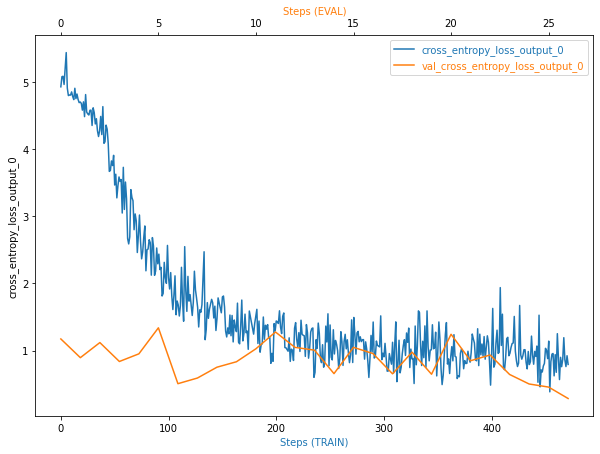

In [36]:
plot_tensor(trial, "cross_entropy_loss_output_0")

The diagram shows that the cross entropy loss quickly decreased, and then slowly goes down from around 2 to around 1. The validation cross entropy loss is different - it goes up at the end. This might indicate some overfitting, where the training loss decreases but the validation loss increases. Strategies like early stopping might help to find a good compromise between minimizing training loss and test loss. Additionally, it could help to use data augmentation to increase the amount of training images.

In [75]:
# TODO: Display the profiler output

In [37]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [38]:
! aws s3 ls {rule_output_path} --recursive

2023-03-19 16:04:40     363340 output/aj-project3-2023-03-19-15-43-32-496/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-19 16:04:39     209369 output/aj-project3-2023-03-19-15-43-32-496/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-19 16:04:35        192 output/aj-project3-2023-03-19-15-43-32-496/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-19 16:04:35        200 output/aj-project3-2023-03-19-15-43-32-496/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-19 16:04:35       1901 output/aj-project3-2023-03-19-15-43-32-496/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-19 16:04:35        127 output/aj-project3-2023-03-19-15-43-32-496/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-19 16:04:35        199 output/aj-project3-2023-03-19-15-43-32-496/rule-output/ProfilerReport/profiler-outp

In [39]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://aj-aws-project3/output/aj-project3-2023-03-19-15-43-32-496/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://aj-aws-project3/output/aj-project3-2023-03-19-15-43-32-496/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://aj-aws-project3/output/aj-project3-2023-03-19-15-43-32-496/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://aj-aws-project3/output/aj-project3-2023-03-19-15-43-32-496/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json to ProfilerReport/profiler-output/profiler-reports/OverallSystemUsage.json
download: s3://aj-aws-project3/output/aj-project3-2023-03-19-15-43-32-

In [40]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [41]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [42]:
import requests
import json

from PIL import Image
import io
from glob import glob
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [43]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [44]:
model_location=estimator.model_data
model_location

's3://aj-aws-project3/output/aj-project3-2023-03-19-15-43-32-496/output/model.tar.gz'

In [45]:
pytorch_inference_model = PyTorchModel(
            entry_point="inference.py",
            role=role,
            model_data=model_location,
            framework_version="1.9",
            py_version="py38",
            predictor_cls=ImagePredictor,
)

In [46]:
# TODO: Deploy your model to an endpoint
predictor = pytorch_inference_model.deploy(
    initial_instance_count=1, 
    instance_type='ml.t2.medium',
)

#predictor=estimator.deploy(    
#    initial_instance_count=1, 
#    instance_type='ml.t2.medium',
#) # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-19-16-17-16-777
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-19-16-17-17-566
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-19-16-17-17-566


----------!

In [51]:
predictor.endpoint_name

'pytorch-inference-2023-03-19-16-17-17-566'

In [52]:
# Label names
dog_names = [item[25:-1] for item in sorted(glob("./dogImages/train/*/"))]

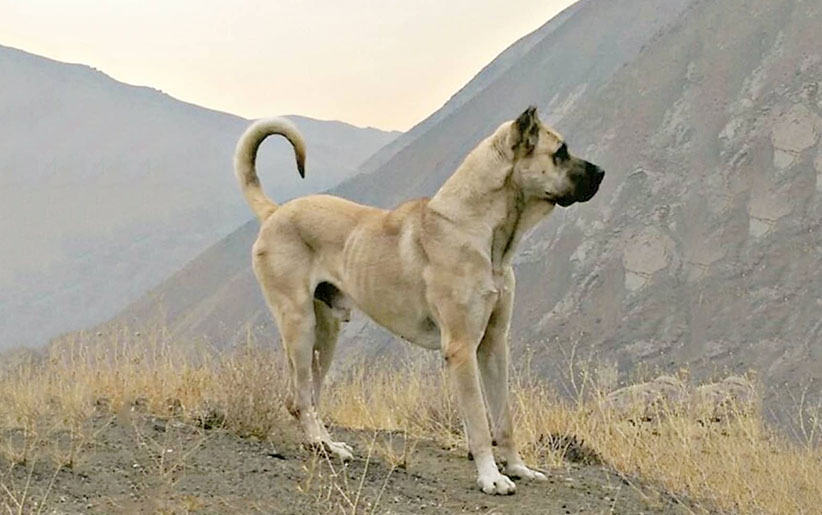

Identified breed: yhound


In [56]:
# TODO: Run an prediction on the endpoint
url = "https://upload.wikimedia.org/wikipedia/commons/7/77/Sarabi-dog.jpg"

image_bytes = requests.get(url).content
response=predictor.predict(image_bytes, initial_args={"ContentType": "image/jpeg"})
display(Image.open(io.BytesIO(image_bytes)))
logits = np.array(response[0])
predicted_index = np.argmax(logits)
print(f"Identified breed: {dog_names[predicted_index]}")

In [57]:
predicted_index

80

In [55]:
dog_names

['enpinscher',
 'han_hound',
 'edale_terrier',
 'ta',
 'skan_malamute',
 'rican_eskimo_dog',
 'rican_foxhound',
 'rican_staffordshire_terrier',
 'rican_water_spaniel',
 'tolian_shepherd_dog',
 'tralian_cattle_dog',
 'tralian_shepherd',
 'tralian_terrier',
 'enji',
 'set_hound',
 'gle',
 'rded_collie',
 'uceron',
 'lington_terrier',
 'gian_malinois',
 'gian_sheepdog',
 'gian_tervuren',
 'nese_mountain_dog',
 'hon_frise',
 'ck_and_tan_coonhound',
 'ck_russian_terrier',
 'odhound',
 'etick_coonhound',
 'der_collie',
 'der_terrier',
 'zoi',
 'ton_terrier',
 'vier_des_flandres',
 'er',
 'kin_spaniel',
 'ard',
 'ttany',
 'ssels_griffon',
 'l_terrier',
 'ldog',
 'lmastiff',
 'rn_terrier',
 'aan_dog',
 'e_corso',
 'digan_welsh_corgi',
 'alier_king_charles_spaniel',
 'sapeake_bay_retriever',
 'huahua',
 'nese_crested',
 'nese_shar-pei',
 'w_chow',
 'mber_spaniel',
 'ker_spaniel',
 'lie',
 'ly-coated_retriever',
 'hshund',
 'matian',
 'die_dinmont_terrier',
 'erman_pinscher',
 'ue_de_bordeaux',


In [58]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-19-16-17-17-566
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-19-16-17-17-566
